# Introduction

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import argparse
import os

# ============================
# --- Improved GridWorld Environment ---
# ============================
class ToyEnv2:
    def __init__(self, grid_size=(5, 5), start=(0, 0), goal=(4, 4), obstacles=None, max_steps=20):
        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.obstacles = set(obstacles) if obstacles else set()
        self.max_steps = max_steps
        self.current_step = 0
        self.state = self.start  # Initial position of the agent
        
        # Observation and Action dimensions
        self.obs_dim = grid_size[0] * grid_size[1]  # One-hot encoding for each grid cell
        self.action_dim = 4  # Up, Down, Left, Right
        
        # Rewards
        self.goal_reward = 10
        self.step_reward = -0.01
        self.obstacle_penalty = -1
        self.timeout_penalty = 0
        self.illegal_penalty = -0.2  # Penalty for hitting boundaries

    def get_state_index(self, state):
        """Convert (x, y) position to flattened state index."""
        return state[0] * self.grid_size[1] + state[1]

    def to_one_hot(self, index):
        """Return one-hot encoded state vector."""
        state = np.zeros(self.obs_dim, dtype=np.float32)
        state[index] = 1.0
        return state

    def reset(self):
        """Reset the environment to the start state."""
        self.state = self.start
        self.current_step = 0
        return self.to_one_hot(self.get_state_index(self.state))

    def step(self, action):
        """Take a step based on the action and return (state, reward, done, info)."""
        if action not in range(self.action_dim):
            raise ValueError(f"Invalid action: {action}. Action must be in [0, 1, 2, 3].")

        moves = {
            0: (-1, 0),  # Up
            1: (1, 0),   # Down
            2: (0, -1),  # Left
            3: (0, 1)    # Right
        }

        dx, dy = moves[action]
        new_state = (self.state[0] + dx, self.state[1] + dy)

        # Check for illegal moves (boundary hit)
        if not (0 <= new_state[0] < self.grid_size[0] and 0 <= new_state[1] < self.grid_size[1]):
            reward = self.illegal_penalty
            done = False
            info = {"info": "Illegal Action (Boundary Hit)"}
            return self.to_one_hot(self.get_state_index(self.state)), reward, done, info

        # Handle obstacle collision
        if new_state in self.obstacles:
            reward = self.obstacle_penalty
            done = False
            info = {"info": "Hit Obstacle"}
        elif new_state == self.goal:
            reward = self.goal_reward
            done = True
            info = {"info": "Goal Reached"}
        elif self.current_step >= self.max_steps - 1:
            reward = self.timeout_penalty
            done = True
            info = {"info": "Max Steps Reached"}
        else:
            reward = self.step_reward
            done = False
            info = {"info": "Step Taken"}

        self.state = new_state
        self.current_step += 1

        return self.to_one_hot(self.get_state_index(new_state)), reward, done, info


# ============================
# --- Harmonic Layer (HarMax) ---
# ============================
class HarmonicLayer(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim=16, n=2):
        super(HarmonicLayer, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.weights = nn.Parameter(torch.randn(output_dim, embedding_dim))
        self.n = n

    def forward(self, x):
        x_embedded = self.embedding(x.argmax(dim=1))  # Add embedding layer
        dist = torch.cdist(x_embedded.unsqueeze(0), self.weights.unsqueeze(0), p=2).squeeze(0)
        inv_dist = 1 / (dist**self.n + 1e-8)
        probs = inv_dist / inv_dist.sum(dim=1, keepdim=True)
        return probs




# ============================
# --- Harmonic Layer with L1 Distance ---
# ============================
class HarmonicLayerL1(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim=16, n=1):
        super(HarmonicLayerL1, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.weights = nn.Parameter(torch.randn(output_dim, embedding_dim))
        self.n = n

    def forward(self, x):
        x_embedded = self.embedding(x.argmax(dim=1))
        dist = torch.cdist(x_embedded.unsqueeze(0), self.weights.unsqueeze(0), p=1).squeeze(0)  # L1 distance
        inv_dist = 1 / (dist**self.n + 1e-8)
        probs = inv_dist / inv_dist.sum(dim=1, keepdim=True)
        return probs

# ============================
# --- Softmax Policy ---
# ============================
class SoftmaxPolicy(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim=16):
        super(SoftmaxPolicy, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim, bias=False)

    def forward(self, x):
        x_embedded = self.embedding(x.argmax(dim=1))
        logits = self.fc(x_embedded)
        return torch.softmax(logits, dim=1)


# ============================
# --- Load Harmonic Model ---
# ============================
def load_harmonic_model(path, input_dim, output_dim, embedding_dim=16):
    model = HarmonicLayer(input_dim=input_dim, output_dim=output_dim, embedding_dim=embedding_dim)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    print(f"✅ Loaded Harmonic Model from {path}")
    return model

# ============================
# --- Load Harmonic L1 Model ---
# ============================
def load_harmonic_l1_model(path, input_dim, output_dim, embedding_dim=16):
    model = HarmonicLayerL1(input_dim=input_dim, output_dim=output_dim, embedding_dim=embedding_dim)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    print(f"✅ Loaded Harmonic L1 Model from {path}")
    return model


# ============================
# --- Load Softmax Model ---
# ============================
def load_softmax_model(path, input_dim, output_dim, embedding_dim=16):
    model = SoftmaxPolicy(input_dim=input_dim, output_dim=output_dim, embedding_dim=embedding_dim)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    print(f"✅ Loaded Softmax Model from {path}")
    return model

# ============================
# --- Environment Setup ---
# ============================
env = ToyEnv2(
    grid_size=(10, 10),
    start=(0, 0),
    goal=(9, 9),
    obstacles={
        (2, 2), (2, 3), (2, 4), (2, 5), (2, 6),
        (5, 2), (5, 3), (5, 4), (5, 5), (5, 6),
        (7, 4), (7, 5), (7, 6), (7, 7),
        (8, 7)
    },
    max_steps=50
)



# ============================
# --- Load Models from 'models' directory ---
# ============================
harmonic_model_path = "models/harmonic_policy_backup.pth"
softmax_model_path = "models/softmax_policy_backup.pth"
harmonic_l1_model_path = "models/harmonic_policy_l1_backup.pth"
# harmonic_l1_model_path = "models/harmonic_policy_l1.pth"

harmonic_policy = load_harmonic_model(harmonic_model_path, input_dim=env.obs_dim, output_dim=env.action_dim)
harmonic_l1_policy = load_harmonic_l1_model(harmonic_l1_model_path, input_dim=env.obs_dim, output_dim=env.action_dim)
softmax_policy = load_softmax_model(softmax_model_path, input_dim=env.obs_dim, output_dim=env.action_dim)


✅ Loaded Harmonic Model from models/harmonic_policy_backup.pth
✅ Loaded Harmonic L1 Model from models/harmonic_policy_l1_backup.pth
✅ Loaded Softmax Model from models/softmax_policy_backup.pth


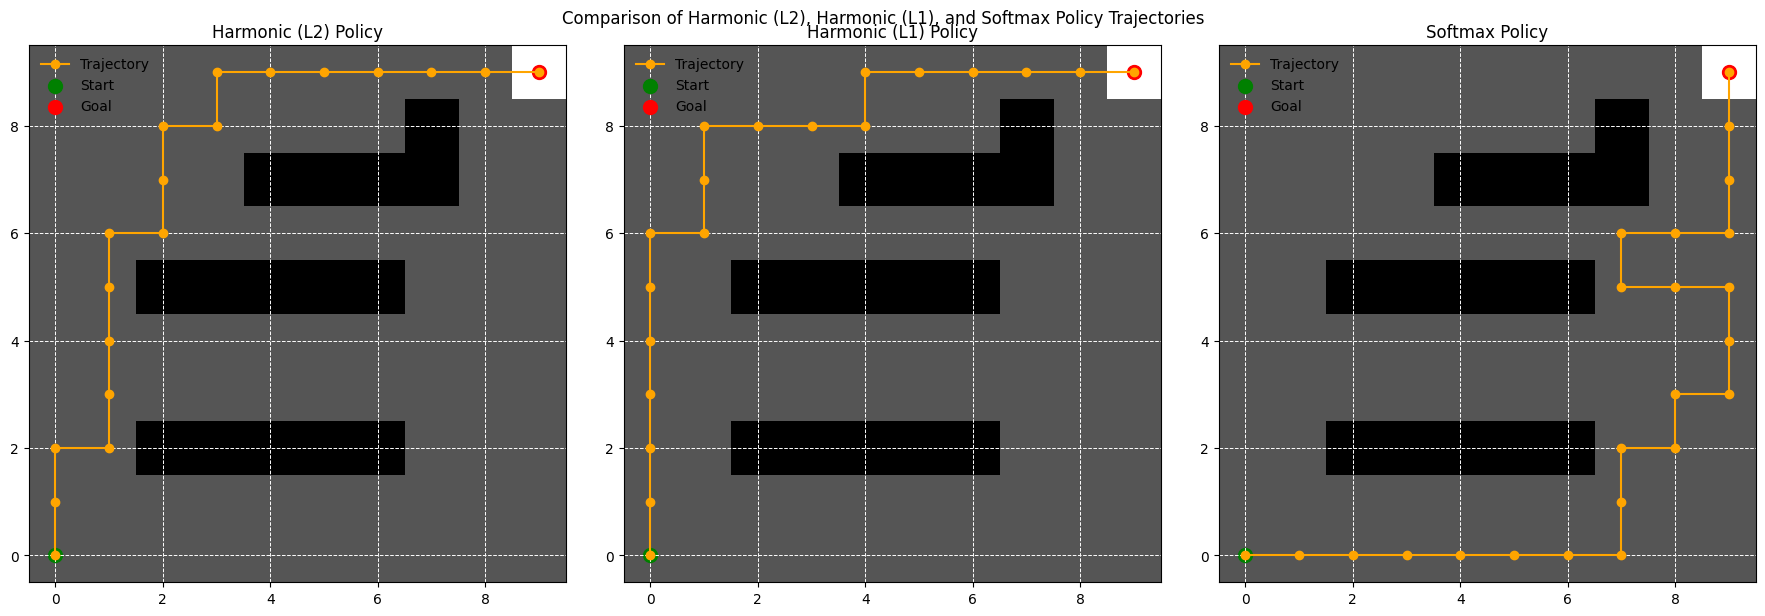

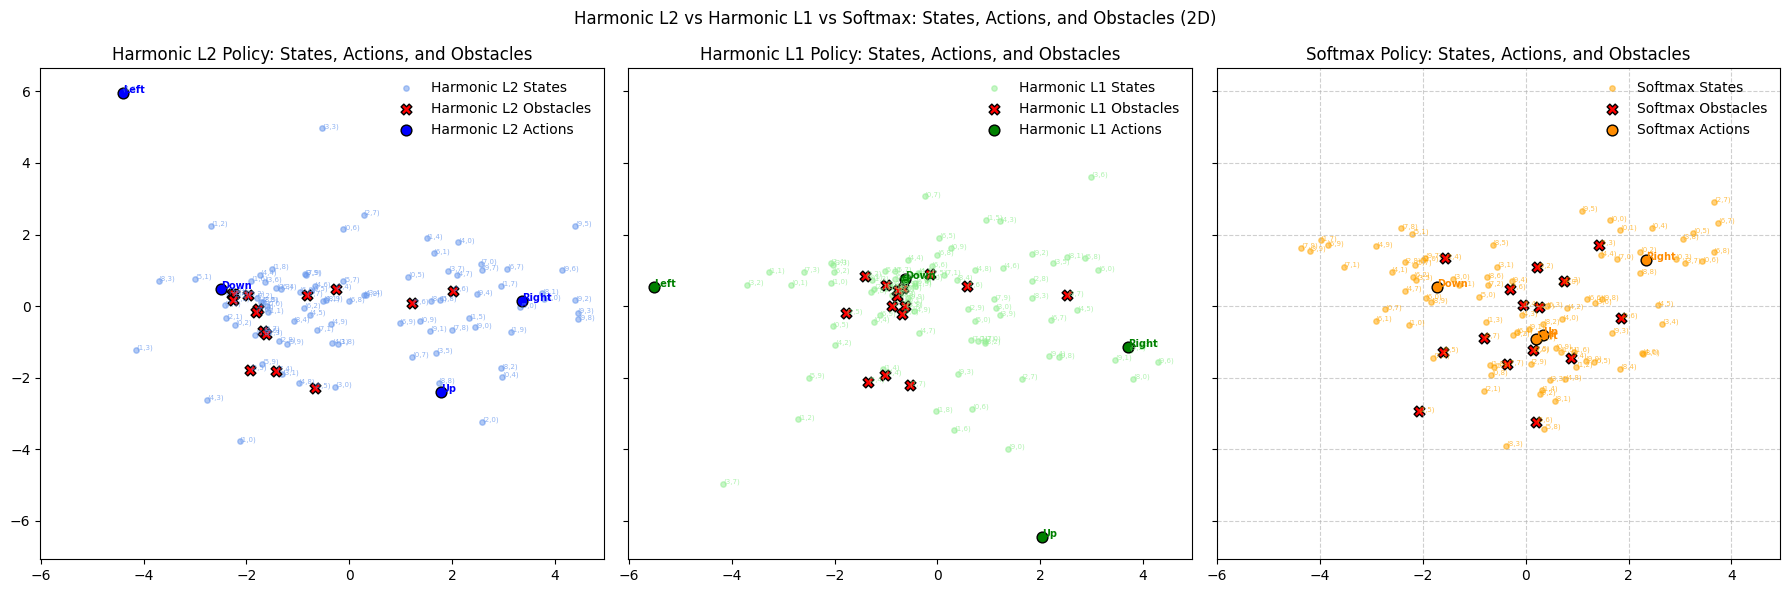

In [21]:
# ============================
# --- State and Action Embeddings Visualization ---
# ============================
def visualize_all_models(harmonic_policy, harmonic_l1_policy, softmax_policy, env, title="State and Action Embeddings with Obstacles"):
    # ============================
    # --- Collect State Embeddings ---
    # ============================
    states = torch.arange(env.obs_dim, dtype=torch.long)  # Long for embedding

    harmonic_state_embeddings = harmonic_policy.embedding(states).detach().numpy()
    harmonic_l1_state_embeddings = harmonic_l1_policy.embedding(states).detach().numpy()
    softmax_state_embeddings = softmax_policy.embedding(states).detach().numpy()

    # ============================
    # --- Collect Action Embeddings ---
    # ============================
    harmonic_action_embeddings = harmonic_policy.weights.detach().numpy()
    harmonic_l1_action_embeddings = harmonic_l1_policy.weights.detach().numpy()
    softmax_action_embeddings = softmax_policy.fc.weight.detach().numpy()

    # ============================
    # --- Perform PCA for Dimensionality Reduction ---
    # ============================
    pca = PCA(n_components=2)

    harmonic_states_2d = pca.fit_transform(harmonic_state_embeddings)
    harmonic_actions_2d = pca.transform(harmonic_action_embeddings)

    harmonic_l1_states_2d = pca.fit_transform(harmonic_l1_state_embeddings)
    harmonic_l1_actions_2d = pca.transform(harmonic_l1_action_embeddings)

    softmax_states_2d = pca.fit_transform(softmax_state_embeddings)
    softmax_actions_2d = pca.transform(softmax_action_embeddings)

    # ============================
    # --- Identify Obstacle States ---
    # ============================
    obstacle_indices = [env.get_state_index(obs) for obs in env.obstacles]

    # ============================
    # --- Moves Dictionary for Action Labels ---
    # ============================
    moves = {
        0: 'Up',
        1: 'Down',
        2: 'Left',
        3: 'Right'
    }

    # ============================
    # --- Plot: Side-by-Side Comparison ---
    # ============================
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

    # ============================
    # --- Helper Function to Plot Each Model ---
    # ============================
    def plot_embeddings(ax, states_2d, actions_2d, color, action_color, model_name):
        ax.scatter(states_2d[:, 0], states_2d[:, 1], color=color, alpha=0.5, label=f'{model_name} States', s=15)
        ax.scatter(
            states_2d[obstacle_indices, 0], states_2d[obstacle_indices, 1],
            color='red', label=f'{model_name} Obstacles', marker='X', s=60, edgecolors='black'
        )
        for i, coord in enumerate(states_2d):
            x, y = divmod(i, env.grid_size[1])  # Convert index to (x, y)
            ax.text(coord[0], coord[1], f"({x},{y})", fontsize=5, alpha=0.7, color=color)

        ax.scatter(actions_2d[:, 0], actions_2d[:, 1], color=action_color, label=f'{model_name} Actions', s=60, edgecolors='black')
        for i, coord in enumerate(actions_2d):
            ax.text(coord[0], coord[1], moves[i], fontsize=7, fontweight='bold', color=action_color)

        ax.set_title(f"{model_name} Policy: States, Actions, and Obstacles")
        ax.legend()

    # ============================
    # --- Plot Each Policy ---
    # ============================
    plot_embeddings(axs[0], harmonic_states_2d, harmonic_actions_2d, 'cornflowerblue', 'blue', "Harmonic L2")
    plot_embeddings(axs[1], harmonic_l1_states_2d, harmonic_l1_actions_2d, 'lightgreen', 'green', "Harmonic L1")
    plot_embeddings(axs[2], softmax_states_2d, softmax_actions_2d, 'orange', 'darkorange', "Softmax")

    plt.suptitle(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
import torch

# ============================
# --- Generalized Agent Trajectory Visualization ---
# ============================
def plot_all_agents(harmonic_policy, harmonic_l1_policy, softmax_policy, env):
    """Plots the trajectories of Harmonic (L2), Harmonic (L1), and Softmax policies side-by-side."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    policies = [
        ("Harmonic (L2) Policy", harmonic_policy, axs[0]),
        ("Harmonic (L1) Policy", harmonic_l1_policy, axs[1]),
        ("Softmax Policy", softmax_policy, axs[2])
    ]

    for title, policy, ax in policies:
        state = env.reset()
        trajectory = [env.state]

        for _ in range(env.max_steps):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action_probs = policy(state_tensor)
            action = torch.argmax(action_probs, dim=1).item()
            next_state, _, done, _ = env.step(action)
            trajectory.append(env.state)
            if done:
                break
            state = next_state

        # --- Construct the Grid for Visualization ---
        grid = np.zeros(env.grid_size)
        for obs in env.obstacles:
            grid[obs] = -1  # Obstacles
        grid[env.goal] = 2  # Goal

        trajectory = np.array(trajectory)

        # --- Plot Trajectory ---
        ax.imshow(grid, cmap="gray", origin="upper")
        ax.plot(
            trajectory[:, 1], trajectory[:, 0],
            marker="o", linestyle="-", color="orange", label="Trajectory"
        )
        ax.scatter(env.start[1], env.start[0], color="green", s=100, label="Start")
        ax.scatter(env.goal[1], env.goal[0], color="red", s=100, label="Goal")

        ax.set_title(title)
        ax.grid(True, color='white', linestyle='--', linewidth=0.7)
        ax.invert_yaxis()
        ax.legend()

    plt.suptitle("Comparison of Harmonic (L2), Harmonic (L1), and Softmax Policy Trajectories")
    plt.tight_layout()
    plt.show()


# ============================
# --- Call Visualization ---
# ============================
plot_all_agents(harmonic_policy, harmonic_l1_policy, softmax_policy, env)

visualize_all_models(
    harmonic_policy,
    harmonic_l1_policy,
    softmax_policy,
    env,
    title="Harmonic L2 vs Harmonic L1 vs Softmax: States, Actions, and Obstacles (2D)"
)
    

### Smaller

✅ Loaded Harmonic Model from models/harmonic_policy_l2.pth
✅ Loaded Harmonic L1 Model from models/harmonic_policy_l1.pth
✅ Loaded Softmax Model from models/softmax_policy.pth


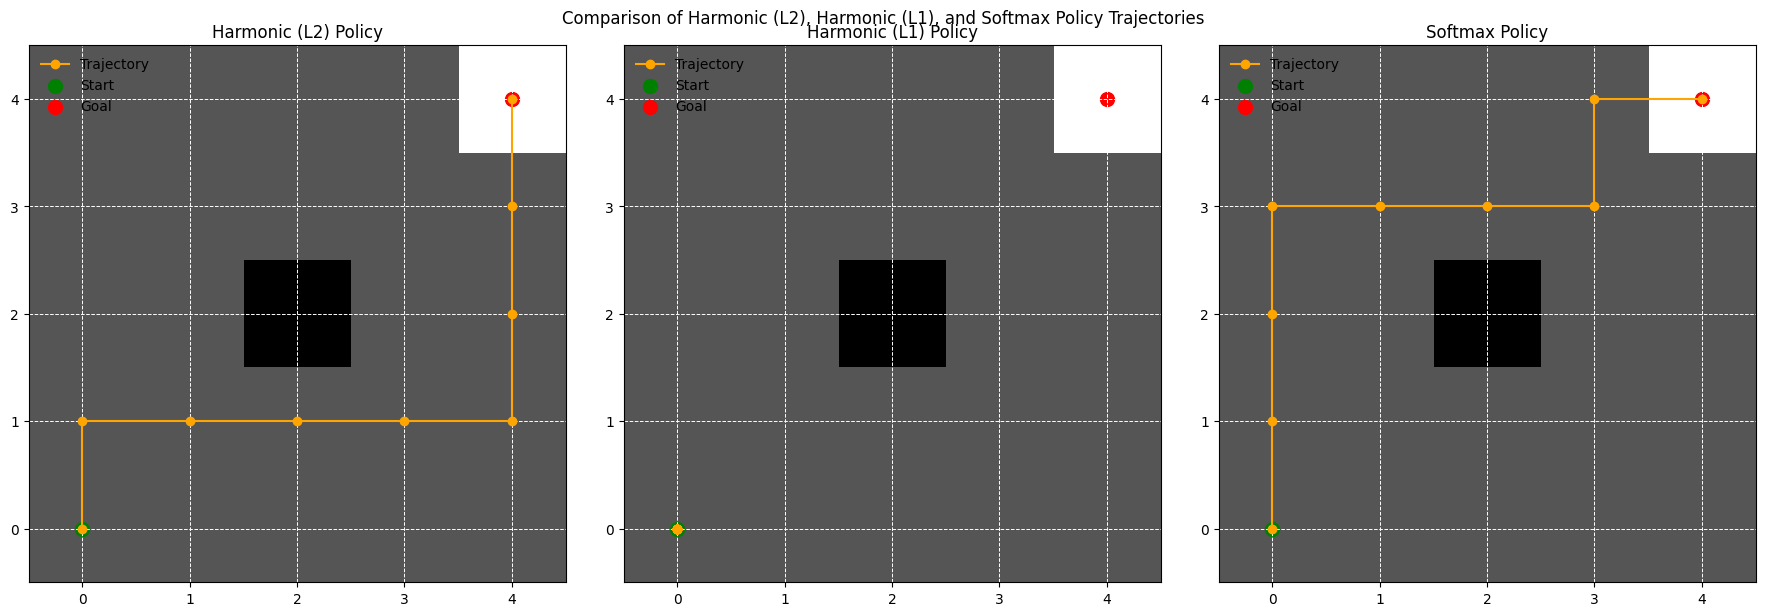

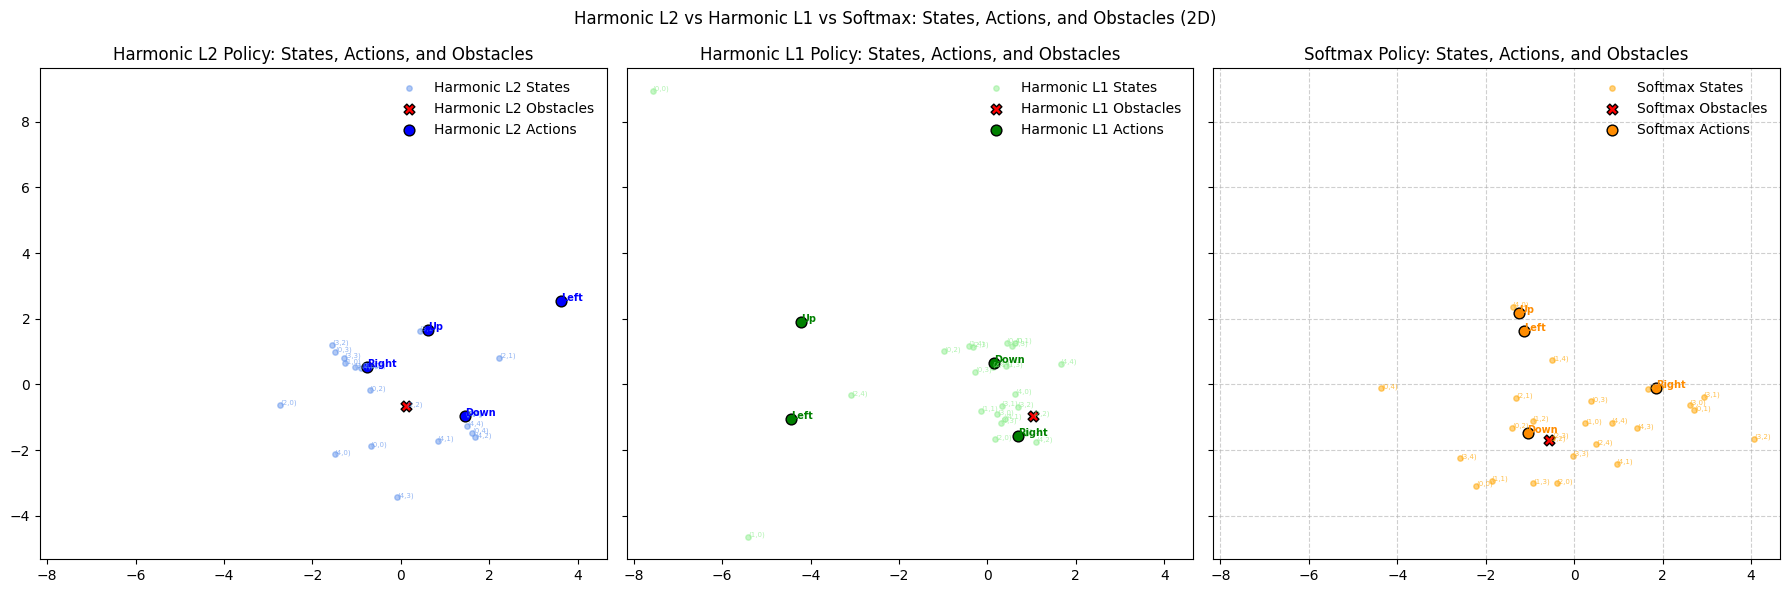

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import argparse
import os

# ============================
# --- Improved GridWorld Environment ---
# ============================
class ToyEnv2:
    def __init__(self, grid_size=(5, 5), start=(0, 0), goal=(4, 4), obstacles=None, max_steps=20):
        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.obstacles = set(obstacles) if obstacles else set()
        self.max_steps = max_steps
        self.current_step = 0
        self.state = self.start  # Initial position of the agent
        
        # Observation and Action dimensions
        self.obs_dim = grid_size[0] * grid_size[1]  # One-hot encoding for each grid cell
        self.action_dim = 4  # Up, Down, Left, Right
        
        # Rewards
        self.goal_reward = 10
        self.step_reward = -0.01
        self.obstacle_penalty = -1
        self.timeout_penalty = 0
        self.illegal_penalty = -0.2  # Penalty for hitting boundaries

    def get_state_index(self, state):
        """Convert (x, y) position to flattened state index."""
        return state[0] * self.grid_size[1] + state[1]

    def to_one_hot(self, index):
        """Return one-hot encoded state vector."""
        state = np.zeros(self.obs_dim, dtype=np.float32)
        state[index] = 1.0
        return state

    def reset(self):
        """Reset the environment to the start state."""
        self.state = self.start
        self.current_step = 0
        return self.to_one_hot(self.get_state_index(self.state))

    def step(self, action):
        """Take a step based on the action and return (state, reward, done, info)."""
        if action not in range(self.action_dim):
            raise ValueError(f"Invalid action: {action}. Action must be in [0, 1, 2, 3].")

        moves = {
            0: (-1, 0),  # Up
            1: (1, 0),   # Down
            2: (0, -1),  # Left
            3: (0, 1)    # Right
        }

        dx, dy = moves[action]
        new_state = (self.state[0] + dx, self.state[1] + dy)

        # Check for illegal moves (boundary hit)
        if not (0 <= new_state[0] < self.grid_size[0] and 0 <= new_state[1] < self.grid_size[1]):
            reward = self.illegal_penalty
            done = False
            info = {"info": "Illegal Action (Boundary Hit)"}
            return self.to_one_hot(self.get_state_index(self.state)), reward, done, info

        # Handle obstacle collision
        if new_state in self.obstacles:
            reward = self.obstacle_penalty
            done = False
            info = {"info": "Hit Obstacle"}
        elif new_state == self.goal:
            reward = self.goal_reward
            done = True
            info = {"info": "Goal Reached"}
        elif self.current_step >= self.max_steps - 1:
            reward = self.timeout_penalty
            done = True
            info = {"info": "Max Steps Reached"}
        else:
            reward = self.step_reward
            done = False
            info = {"info": "Step Taken"}

        self.state = new_state
        self.current_step += 1

        return self.to_one_hot(self.get_state_index(new_state)), reward, done, info


# ============================
# --- Harmonic Layer (HarMax) ---
# ============================
class HarmonicLayer(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim=16, n=2):
        super(HarmonicLayer, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.weights = nn.Parameter(torch.randn(output_dim, embedding_dim))
        self.n = n

    def forward(self, x):
        x_embedded = self.embedding(x.argmax(dim=1))  # Add embedding layer
        dist = torch.cdist(x_embedded.unsqueeze(0), self.weights.unsqueeze(0), p=2).squeeze(0)
        inv_dist = 1 / (dist**self.n + 1e-8)
        probs = inv_dist / inv_dist.sum(dim=1, keepdim=True)
        return probs




# ============================
# --- Harmonic Layer with L1 Distance ---
# ============================
class HarmonicLayerL1(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim=16, n=1):
        super(HarmonicLayerL1, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.weights = nn.Parameter(torch.randn(output_dim, embedding_dim))
        self.n = n

    def forward(self, x):
        x_embedded = self.embedding(x.argmax(dim=1))
        dist = torch.cdist(x_embedded.unsqueeze(0), self.weights.unsqueeze(0), p=1).squeeze(0)  # L1 distance
        inv_dist = 1 / (dist**self.n + 1e-8)
        probs = inv_dist / inv_dist.sum(dim=1, keepdim=True)
        return probs

# ============================
# --- Softmax Policy ---
# ============================
class SoftmaxPolicy(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim=16):
        super(SoftmaxPolicy, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim, bias=False)

    def forward(self, x):
        x_embedded = self.embedding(x.argmax(dim=1))
        logits = self.fc(x_embedded)
        return torch.softmax(logits, dim=1)


# ============================
# --- Load Harmonic Model ---
# ============================
def load_harmonic_model(path, input_dim, output_dim, embedding_dim=2):
    model = HarmonicLayer(input_dim=input_dim, output_dim=output_dim, embedding_dim=embedding_dim)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    print(f"✅ Loaded Harmonic Model from {path}")
    return model

# ============================
# --- Load Harmonic L1 Model ---
# ============================
def load_harmonic_l1_model(path, input_dim, output_dim, embedding_dim=2):
    model = HarmonicLayerL1(input_dim=input_dim, output_dim=output_dim, embedding_dim=embedding_dim)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    print(f"✅ Loaded Harmonic L1 Model from {path}")
    return model


# ============================
# --- Load Softmax Model ---
# ============================
def load_softmax_model(path, input_dim, output_dim, embedding_dim=2):
    model = SoftmaxPolicy(input_dim=input_dim, output_dim=output_dim, embedding_dim=embedding_dim)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    print(f"✅ Loaded Softmax Model from {path}")
    return model

# ============================
# --- Environment Setup ---
# ============================

# Create the Harder ToyEnv2 environment
env = ToyEnv2(
    grid_size=(5, 5),
    start=(0, 0),
    goal=(4, 4),
    obstacles={(2, 2)},  # Single obstacle in the center
    max_steps=20
)



# ============================
# --- Load Models from 'models' directory ---
# ============================
harmonic_model_path = "models/harmonic_policy_l2.pth"
softmax_model_path = "models/softmax_policy.pth"
harmonic_l1_model_path = "models/harmonic_policy_l1.pth"
# harmonic_l1_model_path = "models/harmonic_policy_l1.pth"

harmonic_policy = load_harmonic_model(harmonic_model_path, input_dim=env.obs_dim, output_dim=env.action_dim)
harmonic_l1_policy = load_harmonic_l1_model(harmonic_l1_model_path, input_dim=env.obs_dim, output_dim=env.action_dim)
softmax_policy = load_softmax_model(softmax_model_path, input_dim=env.obs_dim, output_dim=env.action_dim)



# ============================
# --- State and Action Embeddings Visualization ---
# ============================
def visualize_all_models(harmonic_policy, harmonic_l1_policy, softmax_policy, env, title="State and Action Embeddings with Obstacles"):
    # ============================
    # --- Collect State Embeddings ---
    # ============================
    states = torch.arange(env.obs_dim, dtype=torch.long)  # Long for embedding

    harmonic_state_embeddings = harmonic_policy.embedding(states).detach().numpy()
    harmonic_l1_state_embeddings = harmonic_l1_policy.embedding(states).detach().numpy()
    softmax_state_embeddings = softmax_policy.embedding(states).detach().numpy()

    # ============================
    # --- Collect Action Embeddings ---
    # ============================
    harmonic_action_embeddings = harmonic_policy.weights.detach().numpy()
    harmonic_l1_action_embeddings = harmonic_l1_policy.weights.detach().numpy()
    softmax_action_embeddings = softmax_policy.fc.weight.detach().numpy()


    # ============================
    # --- Collect State and Action Embeddings (No PCA) ---
    # ============================
    harmonic_states_2d = harmonic_state_embeddings
    harmonic_actions_2d = harmonic_action_embeddings

    harmonic_l1_states_2d = harmonic_l1_state_embeddings
    harmonic_l1_actions_2d = harmonic_l1_action_embeddings

    softmax_states_2d = softmax_state_embeddings
    softmax_actions_2d = softmax_action_embeddings


    # ============================
    # --- Identify Obstacle States ---
    # ============================
    obstacle_indices = [env.get_state_index(obs) for obs in env.obstacles]

    # ============================
    # --- Moves Dictionary for Action Labels ---
    # ============================
    moves = {
        0: 'Up',
        1: 'Down',
        2: 'Left',
        3: 'Right'
    }

    # ============================
    # --- Plot: Side-by-Side Comparison ---
    # ============================
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

    # ============================
    # --- Helper Function to Plot Each Model ---
    # ============================
    def plot_embeddings(ax, states_2d, actions_2d, color, action_color, model_name):
        ax.scatter(states_2d[:, 0], states_2d[:, 1], color=color, alpha=0.5, label=f'{model_name} States', s=15)
        ax.scatter(
            states_2d[obstacle_indices, 0], states_2d[obstacle_indices, 1],
            color='red', label=f'{model_name} Obstacles', marker='X', s=60, edgecolors='black'
        )
        for i, coord in enumerate(states_2d):
            x, y = divmod(i, env.grid_size[1])  # Convert index to (x, y)
            ax.text(coord[0], coord[1], f"({x},{y})", fontsize=5, alpha=0.7, color=color)

        ax.scatter(actions_2d[:, 0], actions_2d[:, 1], color=action_color, label=f'{model_name} Actions', s=60, edgecolors='black')
        for i, coord in enumerate(actions_2d):
            ax.text(coord[0], coord[1], moves[i], fontsize=7, fontweight='bold', color=action_color)

        ax.set_title(f"{model_name} Policy: States, Actions, and Obstacles")
        ax.legend()

    # ============================
    # --- Plot Each Policy ---
    # ============================
    plot_embeddings(axs[0], harmonic_states_2d, harmonic_actions_2d, 'cornflowerblue', 'blue', "Harmonic L2")
    plot_embeddings(axs[1], harmonic_l1_states_2d, harmonic_l1_actions_2d, 'lightgreen', 'green', "Harmonic L1")
    plot_embeddings(axs[2], softmax_states_2d, softmax_actions_2d, 'orange', 'darkorange', "Softmax")

    plt.suptitle(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# ============================
# --- Generalized Agent Trajectory Visualization ---
# ============================
def plot_all_agents(harmonic_policy, harmonic_l1_policy, softmax_policy, env):
    """Plots the trajectories of Harmonic (L2), Harmonic (L1), and Softmax policies side-by-side."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    policies = [
        ("Harmonic (L2) Policy", harmonic_policy, axs[0]),
        ("Harmonic (L1) Policy", harmonic_l1_policy, axs[1]),
        ("Softmax Policy", softmax_policy, axs[2])
    ]

    for title, policy, ax in policies:
        state = env.reset()
        trajectory = [env.state]

        for _ in range(env.max_steps):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action_probs = policy(state_tensor)
            action = torch.argmax(action_probs, dim=1).item()
            next_state, _, done, _ = env.step(action)
            trajectory.append(env.state)
            if done:
                break
            state = next_state

        # --- Construct the Grid for Visualization ---
        grid = np.zeros(env.grid_size)
        for obs in env.obstacles:
            grid[obs] = -1  # Obstacles
        grid[env.goal] = 2  # Goal

        trajectory = np.array(trajectory)

        # --- Plot Trajectory ---
        ax.imshow(grid, cmap="gray", origin="upper")
        ax.plot(
            trajectory[:, 1], trajectory[:, 0],
            marker="o", linestyle="-", color="orange", label="Trajectory"
        )
        ax.scatter(env.start[1], env.start[0], color="green", s=100, label="Start")
        ax.scatter(env.goal[1], env.goal[0], color="red", s=100, label="Goal")

        ax.set_title(title)
        ax.grid(True, color='white', linestyle='--', linewidth=0.7)
        ax.invert_yaxis()
        ax.legend()

    plt.suptitle("Comparison of Harmonic (L2), Harmonic (L1), and Softmax Policy Trajectories")
    plt.tight_layout()
    plt.show()


# ============================
# --- Call Visualization ---
# ============================
plot_all_agents(harmonic_policy, harmonic_l1_policy, softmax_policy, env)

visualize_all_models(
    harmonic_policy,
    harmonic_l1_policy,
    softmax_policy,
    env,
    title="Harmonic L2 vs Harmonic L1 vs Softmax: States, Actions, and Obstacles (2D)"
)